In [1]:
%matplotlib inline
# Computación científica
import numpy as np

# Gráficos
import matplotlib.pyplot as plt

# Mapas de colores
from matplotlib import cm

# Funciones especiales
from scipy.special import erf, erfc

In [2]:
#PARÁMETROS FÍSICOS DEL PROBLEMA

#Longitud del dominio en x [m]
Lx = 5000

#Ancho del río [m]
w = 100

#Coeficiente de decaimiento químico
ke = 1.16e-4 #[1/s]

#Coeficiente de difusión turbulento promedio
D = 0.5 #[m^2/s]

#Velocidad en x
u0 = 0.17 #[m/s]
#Velocidad en y
v0 = 0

h = 0 #Posición inicial del difusor en y [m]
Wd = 20.0 #Longitud del difusor [m]

#Condiciones iniciales (borde)
C0 = 1 #Concentración del difusor [mg/L]
CB = 0.0 #Concentración del contaminante antes del difusor

In [3]:
#Definimos malla
# Numero de nodos en x
Nx = 1001
# Numero de nodos en y
Ny = 41

x = np.linspace(0.0, Lx, Nx)
y = np.linspace(0.0, w,  Ny)

dx = Lx/(Nx-1)
dy = w/(Ny-1)

#Vemos el espaciamiento
print("dx = %.3f, dy = %.3f m" % (dx, dy))


dx = 5.000, dy = 2.500 m


In [4]:
# Definimos los valores de coeficientes constantes

# Coeficiente correspondiente a nodo vecino derecho
a = 0

# Coeficiente correspondiente a nodo vecino izquierdo
b = -u0 /dx

# Coeficiente correspondiente a nodo vecino superior
c = -(D/(dy**2))

# Coeficiente correspondiente a nodo vecino inferior
d = -(v0/(dy)) - (D/dy**2)

# Coeficiente correspondiente a nodo central
e = u0/dx + v0/dy + (2*D)/(dy**2) + ke

# Coeficiente correspondiente a término constante
f = 0

In [5]:
#Parámetros del SOR
omega = 1.45
tol = 1e-6

# Algoritmo de iteración por SOR

# Inicializamos arreglo para almacenar los valores solución de la concentration
cC = np.ones((Nx,Ny))*C0

# Aplicamos las condiciones de borde 
for j in range(Ny):
    y1 = j*dy
    if y1<= h or y1> h + Wd:
        cC[0,j]= CB
    else:
        cC[0,j]= C0


cC[:,0]= (4*cC[:,1]- cC[:,2])/ 3
cC[:,-1]= (4*cC[:,-2]- cC[:,-3])/ 3

# Inicializamos el residuo total al comienzo de iteración con un valor arbitrario
residuo_total = 1

# Inicializamos contador para numero de iteraciones  
cnt_it = 0


#Iteración SOR
while residuo_total > tol:
    
    suma_residuos = 0.0
    nodos_actualizados = 0
    
    # Recorrer puntos internos del dominio
    for i in range(1,Nx):
        for j in range(1,Ny-1):
            
            # Calcular residuo para nodo (i,j)
            residuo_nodo =b*cC[i-1,j] + c*cC[i,j+1] + d*cC[i,j-1] + e*cC[i,j] - f
            
            # Actualizar el valor de concentracion
            cC[i,j] += -omega*residuo_nodo / e
            suma_residuos += abs(residuo_nodo)
            nodos_actualizados += 1

    
    # Actualizar condiciones de borde arreglo solución de concentraciones 
    for j in range(Ny):
        y1 = j * dy
        if y1<=h or y1>h + Wd:
            cC[0,j] = CB
        else:
            cC[0,j] = C0

    cC[:,0] = (4*cC[:,1] - cC[:,2])/ 3
    cC[:,-1] = (4*cC[:,-2] - cC[:,-3])/ 3
    
    residuo_total = suma_residuos/ max(1, nodos_actualizados)

    if cnt_it % 100 == 0:
        print(f"Iter {cnt_it:5d}, residuo = {residuo_total:.3e}")

    cnt_it += 1


Iter     0, residuo = 8.582e-04
Iter   100, residuo = 4.471e-04
Iter   200, residuo = 2.559e-04
Iter   300, residuo = 1.648e-04
Iter   400, residuo = 1.304e-04
Iter   500, residuo = 1.290e-04
Iter   600, residuo = 1.495e-04
Iter   700, residuo = 1.833e-04
Iter   800, residuo = 8.953e-05


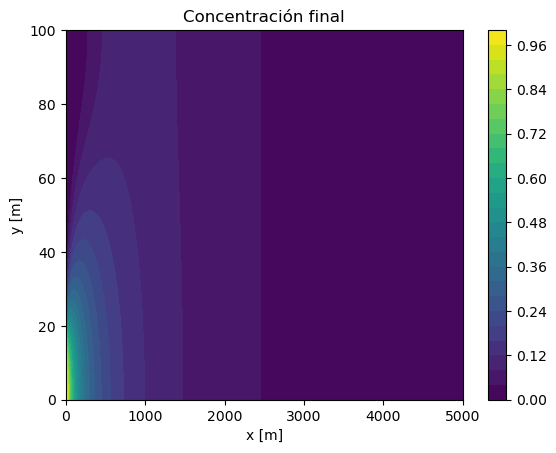

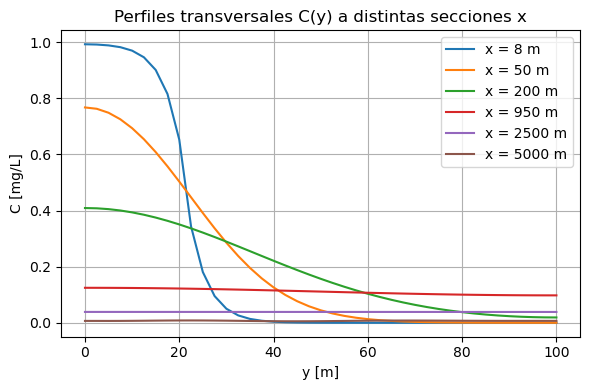

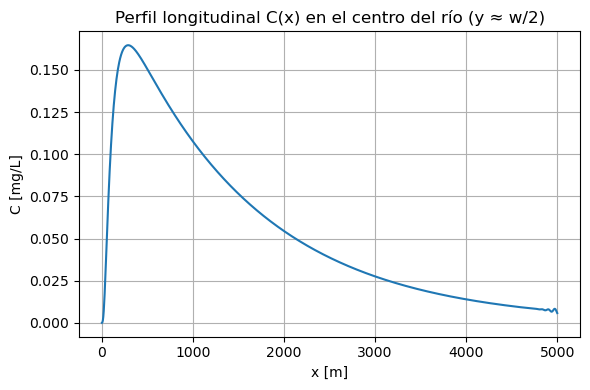

In [7]:
# GRÁFICOS

# Mapa 2D C(x,y)
X, Y = np.meshgrid(x, y, indexing="ij")
plt.contourf(X, Y, cC, levels=30)
plt.colorbar()
plt.title("Concentración final")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.show()


# Perfiles C(y) a distintas x
x_variables = [8, 50, 200, 950, 2500, 5000] #distintas x, se pueden cambiar para ver como cambia C(y)
idxs = [min(len(x)-1, int(xt/dx)) for xt in x_variables]

plt.figure(figsize=(6,4))
for xt, k in zip(x_variables, idxs):
    plt.plot(y, cC[k, :], label=f"x = {xt:g} m")

plt.xlabel("y [m]")
plt.ylabel("C [mg/L]")
plt.legend()
plt.grid(True)
plt.title("Perfiles transversales C(y) a distintas secciones x")
plt.tight_layout()
plt.show()


# Perfil a lo largo del río en el centro
j_centro = np.argmin(np.abs(y - w/2))
plt.figure(figsize=(6,4))
plt.plot(x, cC[:, j_centro])
plt.xlabel("x [m]")
plt.ylabel("C [mg/L]")
plt.grid(True)
plt.title("Perfil longitudinal C(x) en el centro del río (y ≈ w/2)")
plt.tight_layout()
plt.show()
